In [1]:
# base 
import os 
import sys
from src import helpers, config, plotting, evaluation
import random 
import json 
import numpy as np
import pandas as pd 
import pandas.api.types as types
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import missingno as msno
import pickle
import logging
from pathlib import Path
from urllib.request import urlretrieve 
from typing import List, Set, Dict, Tuple
from typing import Union, Any, Optional, Iterable, Hashable, Type

# base
from sklearn.base import TransformerMixin

# ml preprocessing 
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler

# models
import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression

# validation 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, cross_validate, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, roc_curve, roc_auc_score, precision_score, recall_score, plot_confusion_matrix

# pipelines 
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.metrics import make_scorer

# ignore warnings 
import warnings 
warnings.filterwarnings('ignore')

from sklearn import set_config
set_config(display='diagram')


# yet to arrange
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer 
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
# test
assert config.TRAIN_FILE_PATH == Path.cwd().parent / "data" / "final"
assert config.REPORTS_PATH == Path.cwd().parent / "reports" / "figures"
assert config.RAW_FILE_PATH == Path.cwd().parent / "data" / "raw"

In [3]:
%matplotlib inline 
sns.set_style('white')
sns.set_palette('deep')
mpl.rcParams['figure.figsize'] = config.DEFAULT_FIGSIZE
mpl.rcParams['lines.linewidth'] = config.DEFAULT_PLOT_LINEWIDTH
mpl.rcParams['lines.linestyle'] = config.DEFAULT_PLOT_LINESTYLE
mpl.rcParams['font.size'] = config.DEFAULT_AXIS_FONT_SIZE

# logging settings 
# logging.basicConfig(level=logging.DEBUG, format='%(levelname)s:%(message)s')
logger = logging.getLogger()
logger.disabled = False

pd.set_option('display.max_columns', 30)
TARGET = 'status'

In [4]:
# download and place data in the raw folder
raw_filename = 'Loan_Default.csv'
if os.path.exists(config.RAW_FILE_PATH / raw_filename): 
    print(f'READING FROM THE LOCAL COPY')
    df = pd.read_csv(config.RAW_FILE_PATH / raw_filename)
else: 
    print(f'FILE DOES NOT EXIST: {raw_filename}')
    print('DOWNLOADING DATA >>>')
    df = pd.read_csv('gs://aml_1/Loan_Default.csv')
    df.to_csv(config.RAW_FILE_PATH / raw_filename)
df.head()

READING FROM THE LOCAL COPY


,Unnamed: 0,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,loan_amount,rate_of_interest,Interest_rate_spread,Upfront_charges,...,construction_type,occupancy_type,Secured_by,total_units,income,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1
0,0,24890,2019,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,116500,NaN,NaN,NaN,...,sb,pr,home,1U,1740.0,EXP,758,CIB,25-34,to_inst,98.728814,south,direct,1,45.0
1,1,24891,2019,cf,Male,nopre,type2,p1,l1,nopc,b/c,206500,NaN,NaN,NaN,...,sb,pr,home,1U,4980.0,EQUI,552,EXP,55-64,to_inst,NaN,North,direct,1,NaN
2,2,24892,2019,cf,Male,pre,type1,p1,l1,nopc,nob/c,406500,4.56,0.2000,595.0,...,sb,pr,home,1U,9480.0,EXP,834,CIB,35-44,to_inst,80.019685,south,direct,0,46.0
3,3,24893,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,456500,4.25,0.6810,NaN,...,sb,pr,home,1U,11880.0,EXP,587,CIB,45-54,not_inst,69.376900,North,direct,0,42.0
4,4,24894,2019,cf,Joint,pre,type1,p1,l1,nopc,nob/c,696500,4.00,0.3042,0.0,...,sb,pr,home,1U,10440.0,CRIF,602,EXP,25-34,not_inst,91.886544,North,direct,0,39.0


In [5]:
df.columns = helpers.standardize_cols(df.columns)

### Hypotheses 

1. To drop 
    - unnamed:_0
    - id -> UID
    - year -> No variation 
    - interest_rate_spread -> Not able to discriminate

1. Demographics
    - Gender -> Joint less likely to default -> Change to categorical
        - Engineer whether loan was joint or not??
        - Sex not provided

2. Loan types 
    - loan_type -> what is a type 2 loan? 
    - loan_limit -> missing values -> ncf tends to default more 
    - lump_sum_payment -> remap 
    - approv_in_adv -> NA 908
    - term -> most likely not going to be discriminating
    - interest_only 
    - total_units (number of units bought?)

3. Purpose 
    - loan_purpose -> missing 134
    - credit_worthiness
    - open_credit -> imbalanced might not be worth to compute
    - business_or_commercial -> higher chance of default if biz/comm
    - 

4. Deterministic 
    - construction_type -> to drop 
    - secured_by -> drop 
    - 
    - security_type -> drop
    - open_credit -> drop
    

-dtir1 -- debt to income ratio 

loan_limit                    3344
approv_in_adv                  908
loan_purpose                   134
rate_of_interest             36439
upfront_charges              39642
term                            41
neg_ammortization              121
interest_only                    0
property_value               15098
occupancy_type                   0

In [6]:
df = df.drop(columns=['unnamed:_0', 'id', 'year', 'interest_rate_spread']) 
df = df.drop(columns=['secured_by', 'construction_type', 'security_type'])

status  business_or_commercial
0       nob/c                     0.878694
        b/c                       0.121306
1       nob/c                     0.804252
        b/c                       0.195748
Name: business_or_commercial, dtype: float64

status  total_units
0       1U             0.987200
        2U             0.008632
        3U             0.002160
        4U             0.002008
1       1U             0.979366
        2U             0.013920
        3U             0.004121
        4U             0.002593
Name: total_units, dtype: float64

In [32]:
df.groupby(TARGET)['secured_by'].value_counts()

status  secured_by
0       home          112031
1       home           36606
        land              33
Name: secured_by, dtype: int64

status
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: secured_by, dtype: object

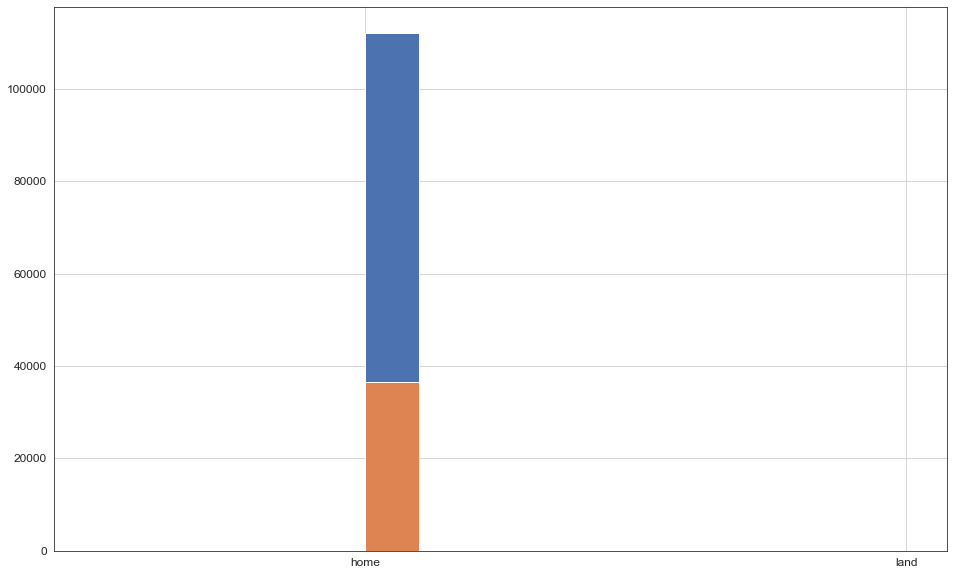

In [31]:
df.groupby(TARGET)['secured_by'].hist()

<AxesSubplot:>

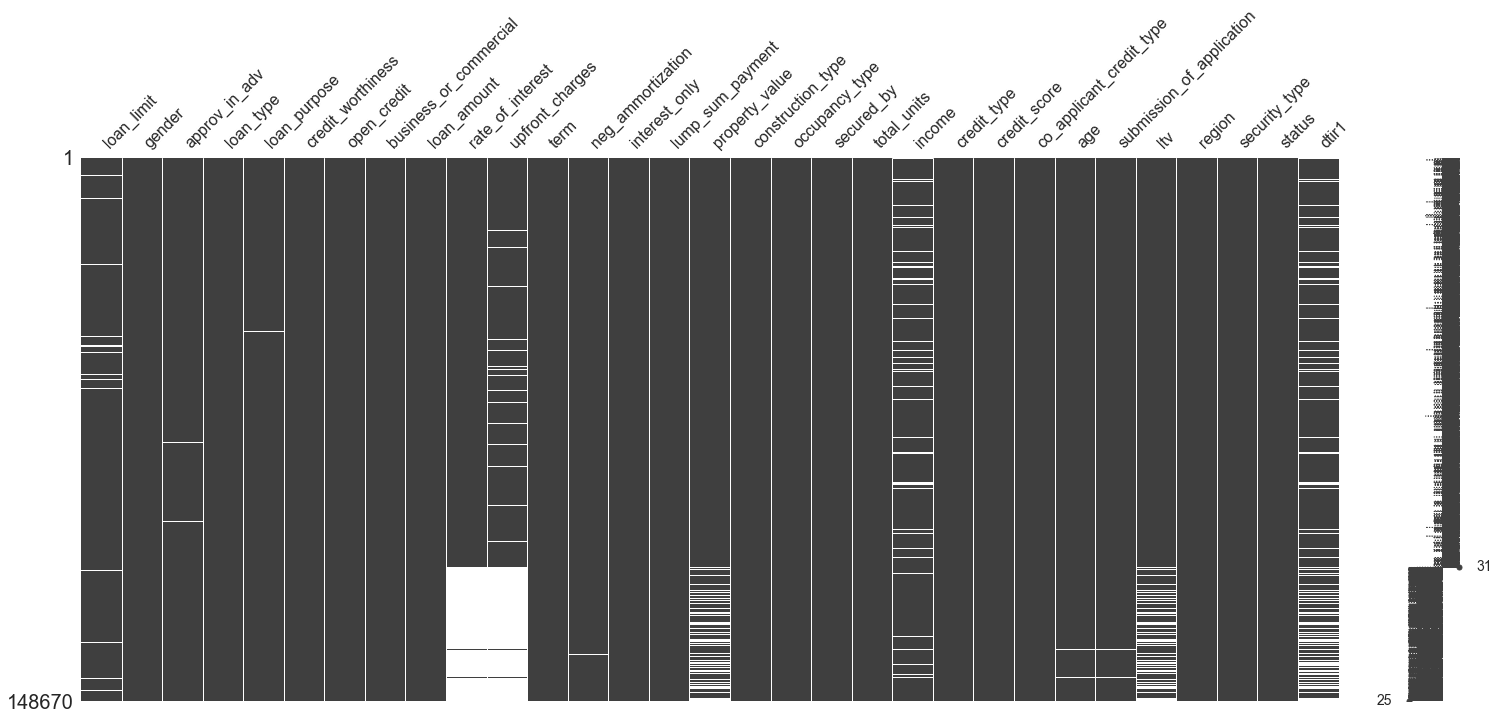

In [7]:
msno.matrix(df.sort_values(by=TARGET))
# plt.savefig(config.REPORTS_PATH / 'target_related_missing.png', dpi=300, bbox_inches='tight')

In [8]:
df['lump_sum_payment']

0         not_lpsm
1             lpsm
2         not_lpsm
3         not_lpsm
4         not_lpsm
            ...   
148665    not_lpsm
148666    not_lpsm
148667    not_lpsm
148668    not_lpsm
148669    not_lpsm
Name: lump_sum_payment, Length: 148670, dtype: object

### Loan type
- Approach - convert to categorical first

In [9]:
df['loan_type'] = helpers.convert_to_dtype(df['loan_type'], 'categorical')

### Loan purpose
- Approach - convert to categorical first

In [10]:
df['loan_purpose'] = helpers.convert_to_dtype(df['loan_purpose'], 'categorical')

### Interest only
- Approach: map to categorical

What Is an Interest-Only Mortgage? An interest-only mortgage is a type of mortgage in which the mortgagor (the borrower) is required to pay only the interest on the loan for a certain period. The principal is repaid either in a lump sum at a specified date, or in subsequent payments.


In [11]:
interest_only_mapping = {'not_int': False, 'int_only': True}  
df['interest_only'] = df['interest_only'].map(interest_only_mapping).astype('category')

df['interest_only'].value_counts()

# check against target
df.groupby(TARGET)['interest_only'].value_counts(normalize=True)

status       
0       False    0.953870
        True     0.046130
1       False    0.946996
        True     0.053004
Name: interest_only, dtype: float64

### Construction type

In [12]:
# df.pivot_table(values=loan, index=TARGET)

df['construction_type'].isna().sum()

0

#### Lump sum payment
- Approach: map to categorical

In [ ]:
df['lump_sum_payment'].value_counts()

lump_sum_mapping = {'not_lpsm': False, 'lpsm': True}  
df['lump_sum_payment'] = df['lump_sum_payment'].map(lump_sum_mapping).astype('category')

df.groupby('status')['lump_sum_payment'].value_counts(normalize=True)

status       
0       False    0.993252
        True     0.006748
1       False    0.928273
        True     0.071727
Name: lump_sum_payment, dtype: float64

#### Co-applicant credit type
- Approach: map to categorical

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148670 entries, 0 to 148669
Data columns (total 31 columns):
 #   Column                     Non-Null Count   Dtype   
---  ------                     --------------   -----   
 0   loan_limit                 145326 non-null  object  
 1   gender                     148670 non-null  object  
 2   approv_in_adv              147762 non-null  object  
 3   loan_type                  148670 non-null  category
 4   loan_purpose               148536 non-null  category
 5   credit_worthiness          148670 non-null  object  
 6   open_credit                148670 non-null  object  
 7   business_or_commercial     148670 non-null  object  
 8   loan_amount                148670 non-null  int64   
 9   rate_of_interest           112231 non-null  float64 
 10  upfront_charges            109028 non-null  float64 
 11  term                       148629 non-null  float64 
 12  neg_ammortization          148549 non-null  object  
 13  interest_only 

In [46]:
df['co_applicant_credit_type'] = df['co_applicant_credit_type'].astype('category')

In [47]:
df['co_applicant_credit_type'].isna().sum()

0

### Credit type
- Convert to categorical first

In [48]:
df['credit_type'].value_counts()

df['credit_type'] = df['credit_type'].astype('category')

### upfront_charges
- Missing values for all status with loan defaults
- ??? 

In [15]:
df.groupby(TARGET)['upfront_charges'].mean()

status
0    3227.328554
1    1565.237974
Name: upfront_charges, dtype: float64

### Interest rate spread

In [16]:
sns.histplot(data=df, x='interest_rate_spread', hue=TARGET)
plt.show()

ValueError: Could not interpret value `interest_rate_spread` for parameter `x`

### Gender

In [ ]:
df['gender'].nunique()
df['gender'].value_counts()

df['gender'] = helpers.convert_to_dtype(df['gender'], type='categorical')

In [ ]:
df['joint_loan'] = df['gender'].apply(lambda x: x == 'Joint')

In [ ]:
msno.heatmap(df)

In [ ]:
msno.dendrogram(df)

In [ ]:
df.shape[0]

In [ ]:
df['loan_limit'].isna().sum()

In [ ]:
missing_loan_limits = df.loc[df['approv_in_adv'].isna()]
non_missing_loan_limits = df.loc[~df['approv_in_adv'].isna()]

In [ ]:
missing_loan_limits = missing_loan_limits.drop(columns='approv_in_adv')

In [ ]:
sns.pairplot(missing_loan_limits)

In [ ]:
display(missing_loan_limits.describe().T)
display(non_missing_loan_limits.describe().T)

In [ ]:
plotting.quick_plot(missing_loan_limits)

In [ ]:
df.groupby(TARGET)['secured_by'].value_counts(normalize=True)

status  secured_by
0       home          1.000000
1       home          0.999099
        land          0.000901
Name: secured_by, dtype: float64

### Business or commercial

In [ ]:
df.groupby(TARGET)['business_or_commercial'].value_counts(normalize=True)

### Debt to income ratio 

In [ ]:
df['dtir1'].isna().sum()
# 24121 missing

24121

In [61]:
df['dtir1'].dtype
# df['dtir1'].hist()

dtype('float64')

### Loan purpose exploration

In [ ]:
df['loan_purpose'].value_counts()

cat_features = helpers.get_categorical_columns(df)

for col in cat_features:
    df_bar = df.groupby('loan_purpose')[col].value_counts().to_frame('counts').reset_index()
    sns.catplot(data=df_bar, x='gender', y='counts', row='loan_purpose', kind='bar')
    plt.show()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148670 entries, 0 to 148669
Data columns (total 31 columns):
 #   Column                     Non-Null Count   Dtype   
---  ------                     --------------   -----   
 0   loan_limit                 145326 non-null  object  
 1   gender                     148670 non-null  object  
 2   approv_in_adv              147762 non-null  object  
 3   loan_type                  148670 non-null  category
 4   loan_purpose               148536 non-null  category
 5   credit_worthiness          148670 non-null  object  
 6   open_credit                148670 non-null  object  
 7   business_or_commercial     148670 non-null  object  
 8   loan_amount                148670 non-null  int64   
 9   rate_of_interest           112231 non-null  float64 
 10  upfront_charges            109028 non-null  float64 
 11  term                       148629 non-null  float64 
 12  neg_ammortization          148549 non-null  object  
 13  interest_only 

### Neg ammortization 

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148670 entries, 0 to 148669
Data columns (total 31 columns):
 #   Column                     Non-Null Count   Dtype   
---  ------                     --------------   -----   
 0   loan_limit                 145326 non-null  object  
 1   gender                     148670 non-null  object  
 2   approv_in_adv              147762 non-null  object  
 3   loan_type                  148670 non-null  category
 4   loan_purpose               148536 non-null  category
 5   credit_worthiness          148670 non-null  object  
 6   open_credit                148670 non-null  object  
 7   business_or_commercial     148670 non-null  object  
 8   loan_amount                148670 non-null  int64   
 9   rate_of_interest           112231 non-null  float64 
 10  upfront_charges            109028 non-null  float64 
 11  term                       148629 non-null  float64 
 12  neg_ammortization          148549 non-null  object  
 13  interest_only 

### Credit score 

<AxesSubplot:>

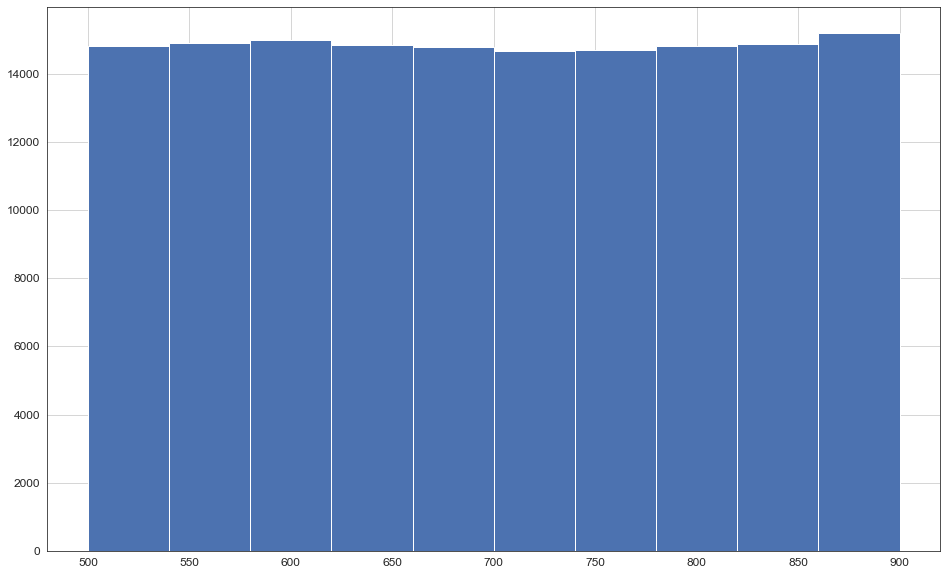

In [21]:
df['credit_score'].hist()

### Income
- Huge outlier in income

In [27]:
df['income'].describe().T

count    139520.000000
mean       6957.338876
std        6496.586382
min           0.000000
25%        3720.000000
50%        5760.000000
75%        8520.000000
max      578580.000000
Name: income, dtype: float64

In [28]:
df[df['income'] == df['income'].max()]

,loan_limit,gender,approv_in_adv,loan_type,loan_purpose,credit_worthiness,open_credit,business_or_commercial,loan_amount,rate_of_interest,upfront_charges,term,neg_ammortization,interest_only,lump_sum_payment,...,construction_type,occupancy_type,secured_by,total_units,income,credit_type,credit_score,co_applicant_credit_type,age,submission_of_application,ltv,region,security_type,status,dtir1
62237,ncf,Sex Not Available,nopre,type1,p3,l1,nopc,nob/c,1086500,NaN,NaN,360.0,neg_amm,False,False,...,sb,pr,home,1U,578580.0,CIB,585,EXP,45-54,to_inst,60.094027,south,direct,1,7.0


### Total units

In [57]:
total_units_categories = pd.CategoricalDtype(categories=['1U', '2U', '3U', '4U'], ordered=True)

In [58]:
df['total_units'] = df['total_units'].astype(total_units_categories)

In [60]:
# df.groupby(TARGET)['total_units'].value_counts(normalize=True)

CategoricalDtype(categories=['1U', '2U', '3U', '4U'], ordered=True)

### Security Type

In [66]:
df.groupby(TARGET)['security_type'].value_counts()

status  security_type
0       direct           112031
1       direct            36606
        Indriect             33
Name: security_type, dtype: int64

### Term

<AxesSubplot:>

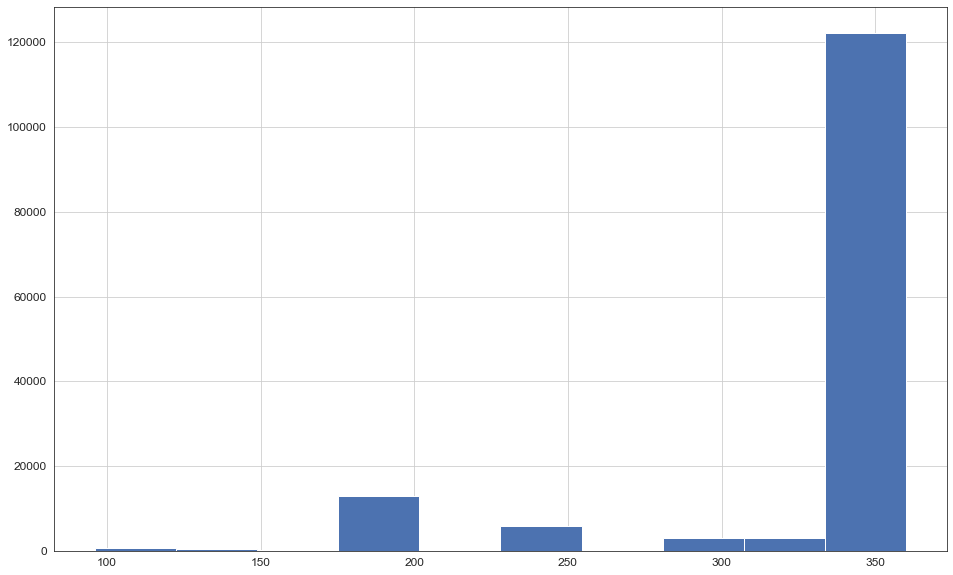

In [29]:
df['term'].hist()